#Problem Statement
Google Street View offers a plethora of images documenting how America looks on the ground. The question we are trying to answer in our project is the following: _Are we able to systematically identify differences in these images that can be used to classify a district as blue or red?_

# Exploring and Visualizing Data 
## Data Summary
Our outcome variable is pulled from the outcome of the 2022 election. Our outcome variable is the binary variable of the outcome of the 2022 election. This variable was calculated by taking the 2022 midterm election results from Bloomberg Election Results and the winner of the election, or the incumbent, determined the party that won the voting district. This voting district is labeled as the [state ID] - [district ID].  

Our X data was randomly sampled from Google Street View across the US. We are able to use web scraping from the following site [(source)](https://randomstreetview.com/us) to gather images and associated zip codes. We then appropriately crop and resize the images and match zip codes to congressional districts via the following site [(source)](https://www.geocod.io/) to create our final dataset.

## Data Description
We ended up with approximately 30% of the images from blue congressional districts and 70% of the images from red congressional districts (based on election results in 2022). 

Since republican districts geographically take up more of the US so if we simply randomly sample latitude and longitudes across a space, we will naturally end up in more congressional districts that voted republican in 2022. 
In our Milestone #5, we want to balance out this dataset by adding some of our data from the University of Central Florida [(source)](https://www.crcv.ucf.edu/data/GMCP_Geolocalization/), which is largely sampled from democratic cities.

![my image](sampled_map.png)

### Processing Image Data

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate
#from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
daniela_path = 'drive/MyDrive/Class/CS209b/CS209b_Final_Project'
elie_path = "drive/MyDrive/CS209b_Final_Project"
daniela_path_gpu = ''
path = daniela_path_gpu

# Define the directory containing the image files
images_directory = path + 'croppedimages_1000/croppedimages/'#'/trial_data/croppedimages/'
outcome_directory = path + ''#'/outcome_data/'

# Creating the Training and Testing Datasets

Here, we first fetch the dataframe that has the image ID and the election result from the 2022 elections into a dataframe called `df_outcome`.

We then create a dataframe with images in the `image` column.

Once these are fetched into on unified dataframe, we creat our `x_train, x_test, y_train, y_test` with 20%-80% split for testing, and then we create a data generator for our tensor flow model pipeline.

In [ ]:
# Define the directory containing the image files
images_directory = path + '/trial_data/croppedimages/'
outcome_directory = path + '/outcome_data/'

# Fetch the dataframe that has the image ID and the election result
df_outcome = pd.read_csv(outcome_directory + "1000img_outcome.csv", index_col="ID")
df_outcome.head()

,Unnamed: 0,DEM,Latitude,Longitude
ID,,,,
0,0,0.0,40.809230,-72.759640
1,1,0.0,40.311418,-86.063107
2,2,0.0,39.445502,-104.852987
3,3,1.0,47.615471,-122.207221
4,4,0.0,37.602800,-99.292610


In [ ]:
# Missing labels from original data has label -1, so we drop these rows
missing_i = df_outcome.loc[df_outcome.DEM < 0].index
df_outcome_updated = df_outcome.drop(missing_i)

In [ ]:
# Define a list to hold the data for each image
data = []

# Sanity check
matches_count = 0

# Loop over each file in the directory
for filename in tqdm(os.listdir(images_directory)):
    match = re.search(r'location(\d+)\.jpg', filename)
    if match:
        matches_count += 1
        image_id = int(match.group(1))
        # Load the image
        filepath = os.path.join(images_directory, filename)
        try: 
            image = Image.open(filepath)
        except: 
            print("Missing image: " + filepath)
            continue
        image = np.array(image)

        # Load the election result (Democrat or Republican)
        try: 
            is_democrat = df_outcome_updated.iloc[image_id]['DEM']
        except: 
            continue
        
        # Append the data to the list
        data.append({'filename': filename, 'image': image, 'ID': image_id, 'DEM': is_democrat})

# Create a dataframe from the data
df = pd.DataFrame(data)

# Sanity check
assert(matches_count == len(os.listdir(images_directory)))

In [ ]:
# Load the data and split into training and testing sets
x = df['image'].to_numpy()
x = np.stack(x, axis=0)
y = df['DEM'].to_numpy().astype('int32')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=109)

# Reshape the image array to be a 4D tensor
x_train = np.reshape(x_train, (x_train.shape[0], 170, 250, 3))
x_test = np.reshape(x_test, (x_test.shape[0], 170, 250, 3))

# Convert the data type of the image arrays to float32 and normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
del x
del y

# Baseline Model

We start out with a simple CNN as our baseline model. 

In [ ]:
# Define the model architecture
model = keras.Sequential([
    # Convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(170,250,3)),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2,2)),
    # Convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(64, (3,3), activation='relu'),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2,2)),
    # Convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(128, (3,3), activation='relu'),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2,2)),
    # Flatten the output of the previous layer
    layers.Flatten(),
    # Fully connected layer with 512 units and ReLU activation
    layers.Dense(2, activation='relu'),
    # Dropout layer with 0.5 dropout rate
    layers.Dropout(0.5),
    # Output layer with 1 unit and sigmoid activation
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 124, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 122, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 29, 128)      0

2023-04-25 02:17:20.665142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 02:17:20.888988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 02:17:20.889295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
# Train the model on the training data
hist_baseline = model.fit(x_train, y_train, epochs=10, batch_size=50, validation_data=(x_test, y_test))

Epoch 1/10


2023-04-25 02:17:48.185459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-25 02:17:50.530033: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-25 02:17:51.198331: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd260e7e640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-25 02:17:51.198372: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-04-25 02:17:51.290139: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-25 02:17:51.727454: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-25 02:17:51.842340: I ./tensorflow/compiler/jit/device_compiler.h:180] Com

154/154 [==============================] - 19s 65ms/step - loss: 0.6793 - accuracy: 0.7191 - val_loss: 0.6654 - val_accuracy: 0.7190
Epoch 2/10
154/154 [==============================] - 8s 54ms/step - loss: 0.6541 - accuracy: 0.7191 - val_loss: 0.6437 - val_accuracy: 0.7190
Epoch 3/10
154/154 [==============================] - 8s 55ms/step - loss: 0.6355 - accuracy: 0.7191 - val_loss: 0.6277 - val_accuracy: 0.7190
Epoch 4/10
154/154 [==============================] - 8s 55ms/step - loss: 0.6218 - accuracy: 0.7191 - val_loss: 0.6165 - val_accuracy: 0.7190
Epoch 5/10
154/154 [==============================] - 8s 55ms/step - loss: 0.6121 - accuracy: 0.7191 - val_loss: 0.6084 - val_accuracy: 0.7190
Epoch 6/10
154/154 [==============================] - 8s 55ms/step - loss: 0.6054 - accuracy: 0.7191 - val_loss: 0.6029 - val_accuracy: 0.7190
Epoch 7/10
154/154 [==============================] - 9s 55ms/step - loss: 0.6010 - accuracy: 0.7191 - val_loss: 0.5994 - val_accuracy: 0.7190
Epoch 8/1

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

61/61 [==============================] - 1s 14ms/step - loss: 0.5949 - accuracy: 0.7190
Test accuracy: 0.7189610600471497


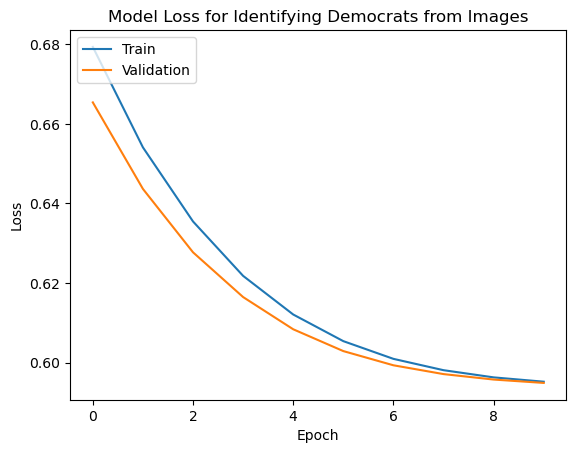

In [ ]:
plt.plot(hist_baseline.history['loss'])
plt.plot(hist_baseline.history['val_loss'])
plt.title('Model Loss for Identifying Democrats from Images')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Interpretation

Our model converges at approximately a 71% train and test accuracy after 10 epochs. The loss for the train and test also converges after 10 epochs. Because our data is skewed republican, our model had difficulty in differentiating between republican and non-republican districts. After analyzing the raw predictions on the test data, our model overclassifies each test image as republican. Thus, this high accuracy may be more reflective of the skewed dataset than the performance of the model. 
This makes sense because our baseline model is very simple and is not able to extract helpful features. 

# Final Model

We will augment our pipeline to add models that can extract certain features that are related to the election outcome. Specifically, we want to detect dense urban environments and rural areas. Based on the literature ([source](https://www.nytimes.com/interactive/2021/04/06/upshot/trump-biden-quiz-photos.html)), images from rural areas are significantly more likely to be from republican precincts than from democratic precincts (this is based on data from the 2020 election). As the literature demonstrates, we can use a U-net to identify green areas and highways as a heuristic for farmland and rural areas ([source](https://etd.ohiolink.edu/apexprod/rws_etd/send_file/send?accession=kent1626962900618429&disposition=inline)). 

### Pipeline

We used a pre-trained Yolo model in order identify the specific features we care about. The Yolo model is trained to identify buildings, cars, people, and trees.

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Load the pre-trained YOLOv3 model
model = tf.keras.models.load_model('path/to/yolo.h5')

# Define the classes that the YOLOv3 model can detect
classes = ['building', 'car', 'person', 'tree']

# Define the threshold for confidence score and non-max suppression
conf_threshold = 0.5
nms_threshold = 0.5

# Loop over the images and detect building features in each image
for img_path in images_directory:
    # Load the image and preprocess it
    img = cv2.imread(img_path)
    img = cv2.resize(img, (250, 170))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)

    # Use the YOLOv3 model to detect objects in the image
    boxes, scores, classes, nums = model.predict(img)

    # Apply non-max suppression to remove overlapping boxes
    indices = tf.image.non_max_suppression(boxes[0], scores[0], max_output_size=-1, iou_threshold=nms_threshold, score_threshold=conf_threshold)
    boxes = tf.gather(boxes[0], indices).numpy()
    scores = tf.gather(scores[0], indices).numpy()
    classes = tf.gather(classes[0], indices).numpy()
    nums = indices.shape[0]

    # Loop over the detected objects and print their class and confidence score
    for i in range(nums):
        class_id = int(classes[i])
        score = scores[i]
        class_name = classes[class_id]
        if class_name == 'building':
            print(f"Image {img_path} contains a building with score {score}")